In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

# Cihaz yapılandırması (GPU varsa kullan, yoksa CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Kullanılan Cihaz: {device}")

# Hiperparametreler
IMG_SIZE = 128
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20
DATA_DIR = "PlantVillage" # Klasör yolunu kontrol et

Kullanılan Cihaz: cpu


In [2]:
# Veri Dönüşümleri (Transforms)
# Keras'taki Rescaling(1./255) işlemi ToTensor() içinde otomatik yapılır.
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(), # Görüntüyü 0-1 arasına çeker ve (C, H, W) formatına çevirir
])

# Veri setini yükle
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

# Sınıf isimlerini al
class_names = full_dataset.classes
n_classes = len(class_names)
print(f"Sınıflar: {class_names}")

# Train/Val Ayırma (%80 Train, %20 Val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoader oluşturma (Batch işlemleri için)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Eğitim verisi sayısı: {len(train_dataset)}")
print(f"Doğrulama verisi sayısı: {len(val_dataset)}")

Sınıflar: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Eğitim verisi sayısı: 16510
Doğrulama verisi sayısı: 4128


In [3]:
class MiniVGGNet(nn.Module):
    def __init__(self, num_classes):
        super(MiniVGGNet, self).__init__()
        
        # --- Blok 1 ---
        # Conv2D(32, (3, 3), padding="same")
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        # MaxPooling2D(pool_size=(3, 3)) -> Stride belirtilmezse kernel_size ile aynı olur
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3) 
        self.dropout1 = nn.Dropout(0.25)
        
        # --- Blok 2 ---
        # Conv2D(64, (3, 3), padding="same")
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        
        # Conv2D(64, (3, 3), padding="same")
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        
        # MaxPooling2D(pool_size=(2, 2))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        # --- Blok 3 ---
        # Conv2D(128, (3, 3), padding="same")
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        
        # Conv2D(128, (3, 3), padding="same")
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.ReLU()
        
        # MaxPooling2D(pool_size=(2, 2))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)
        
        # --- Flatten ve Dense ---
        self.flatten = nn.Flatten()
        
        # Flatten sonrası boyut hesaplaması:
        # Giriş: 128x128
        # Pool1 (3x3, s=3): 128/3 = 42x42
        # Pool2 (2x2, s=2): 42/2 = 21x21
        # Pool3 (2x2, s=2): 21/2 = 10x10
        # Çıkış Kanalları: 128 -> Toplam: 128 * 10 * 10 = 12800
        self.fc1 = nn.Linear(128 * 10 * 10, 1024)
        self.bn_fc = nn.BatchNorm1d(1024) # Dense katmanı için BatchNorm1d kullanılır
        self.relu_fc = nn.ReLU()
        self.dropout_fc = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, num_classes)
        # Not: PyTorch CrossEntropyLoss içinde Softmax otomatik vardır, 
        # o yüzden buraya Softmax eklemiyoruz.

    def forward(self, x):
        # Blok 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Blok 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Blok 3
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.bn4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.bn5(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Dense
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu_fc(x)
        x = self.bn_fc(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        
        return x

# Modeli oluştur ve cihaza gönder
model = MiniVGGNet(num_classes=n_classes).to(device)
print(model)

MiniVGGNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu

In [4]:
# Kayıp Fonksiyonu ve Optimizasyon
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train_epoch(model, loader, criterion, optimizer):
    model.train() # Modeli eğitim moduna al (Dropout ve BN çalışır)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        # 1. Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 2. Backward Pass ve Optimizasyon
        optimizer.zero_grad() # Gradyanları sıfırla
        loss.backward()       # Geri yayılım
        optimizer.step()      # Ağırlıkları güncelle
        
        # İstatistikler
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    return running_loss / len(loader), 100 * correct / total

def validate_epoch(model, loader, criterion):
    model.eval() # Modeli değerlendirme moduna al (Dropout ve BN durur)
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad(): # Gradyan hesaplamayı kapat (Hızlandırır)
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss / len(loader), 100 * correct / total

In [5]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("Eğitim Başlıyor...")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

print("Eğitim Tamamlandı.")

Eğitim Başlıyor...
Epoch [1/20] Train Loss: 0.8440 | Train Acc: 72.68% | Val Loss: 0.5844 | Val Acc: 80.60%
Epoch [2/20] Train Loss: 0.7012 | Train Acc: 77.00% | Val Loss: 0.6369 | Val Acc: 82.32%
Epoch [3/20] Train Loss: 0.4687 | Train Acc: 84.34% | Val Loss: 0.6101 | Val Acc: 88.11%
Epoch [4/20] Train Loss: 0.3880 | Train Acc: 87.00% | Val Loss: 0.7325 | Val Acc: 88.44%
Epoch [5/20] Train Loss: 0.5015 | Train Acc: 83.99% | Val Loss: 0.4687 | Val Acc: 91.25%
Epoch [6/20] Train Loss: 0.6039 | Train Acc: 80.90% | Val Loss: 0.3794 | Val Acc: 87.62%
Epoch [7/20] Train Loss: 0.3478 | Train Acc: 88.39% | Val Loss: 0.5466 | Val Acc: 87.84%
Epoch [8/20] Train Loss: 0.2806 | Train Acc: 90.76% | Val Loss: 0.6143 | Val Acc: 84.13%
Epoch [9/20] Train Loss: 0.2931 | Train Acc: 90.31% | Val Loss: 0.4311 | Val Acc: 88.76%
Epoch [10/20] Train Loss: 0.2259 | Train Acc: 92.50% | Val Loss: 0.5299 | Val Acc: 87.48%
Epoch [11/20] Train Loss: 0.2300 | Train Acc: 92.31% | Val Loss: 0.3274 | Val Acc: 90.55%



--- Classification Report ---
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      0.95      0.96       191
                     Pepper__bell___healthy       0.98      0.99      0.99       332
                      Potato___Early_blight       0.97      0.98      0.97       206
                       Potato___Late_blight       0.94      0.97      0.95       217
                           Potato___healthy       0.93      0.96      0.95        27
                      Tomato_Bacterial_spot       0.97      0.97      0.97       426
                        Tomato_Early_blight       0.90      0.87      0.89       199
                         Tomato_Late_blight       0.97      0.92      0.94       403
                           Tomato_Leaf_Mold       0.99      0.92      0.95       171
                  Tomato_Septoria_leaf_spot       0.96      0.97      0.96       365
Tomato_Spider_mites_Two_spotted_s

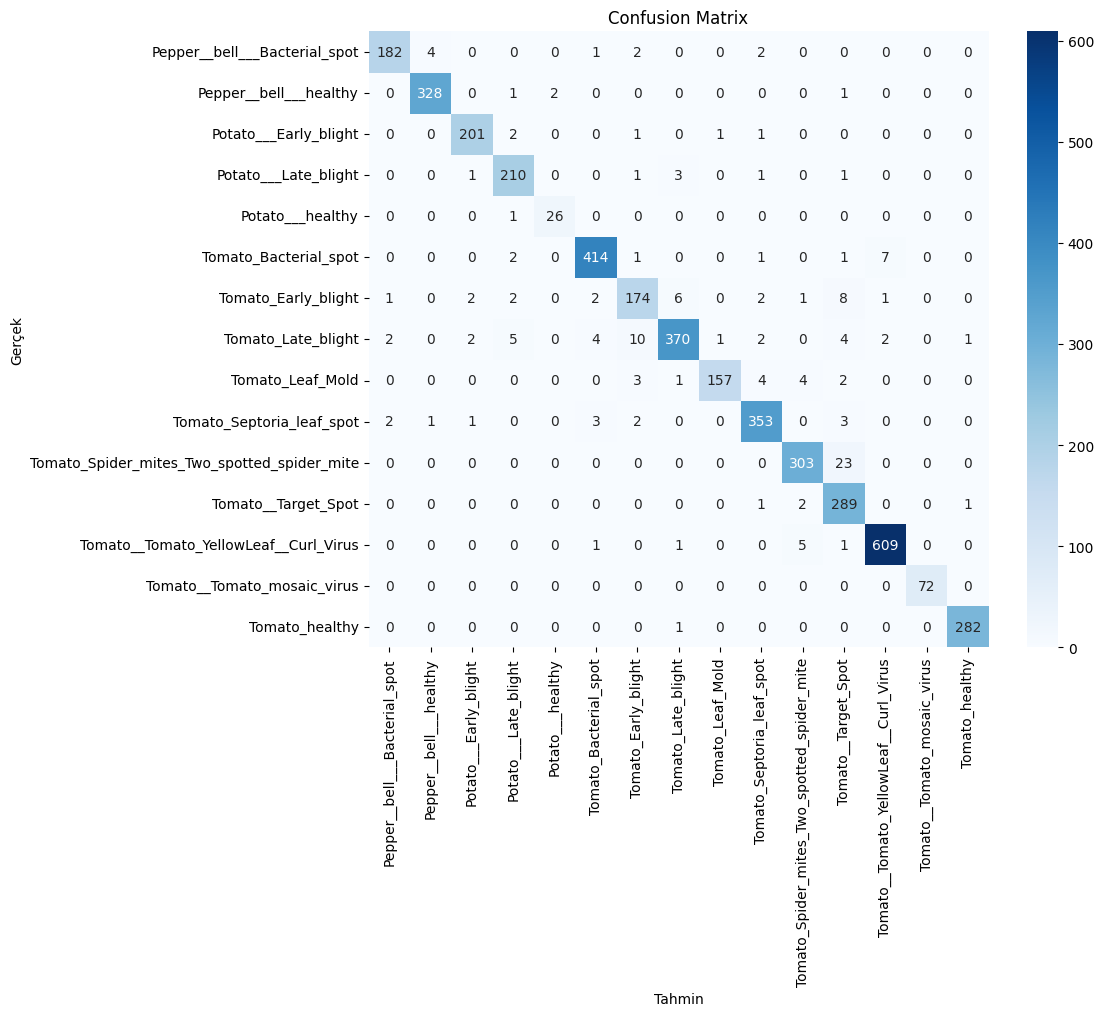

In [7]:
# Tüm validasyon seti üzerinde tahmin yap
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# Isı haritası (Opsiyonel: Seaborn varsa daha güzel görünür)
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.title('Confusion Matrix')
plt.show()

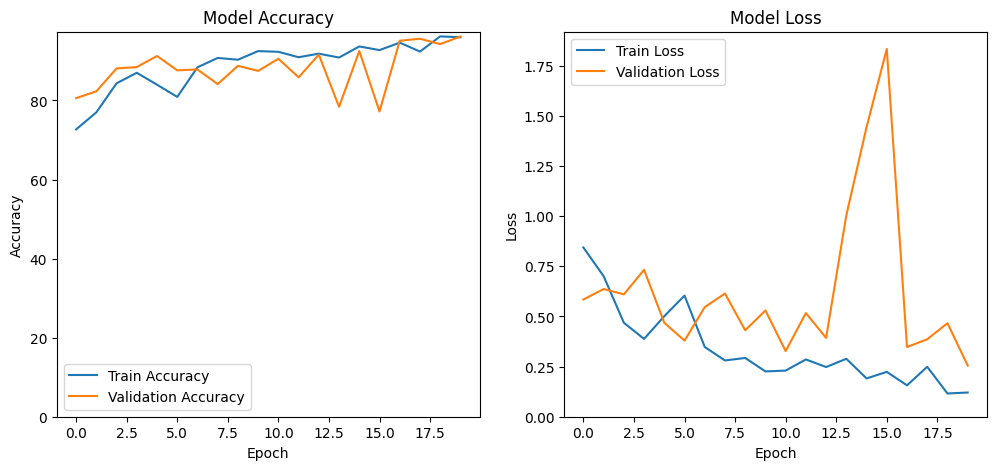

In [9]:
plt.figure(figsize=(12, 5))

# Accuracy Grafiği
plt.subplot(1, 2, 1)

# Eğer verilerin yüzde (0-100) ise ve 0-1 aralığında görmek istiyorsan şu dönüşümü açabilirsin:
# train_accs = [x / 100 for x in train_accs]
# val_accs = [x / 100 for x in val_accs]

plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy') # Yüzde işareti kaldırıldı
plt.legend()
plt.ylim(bottom=0) # Y eksenini 0 ile 1 arasına sabitler

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(bottom=0) # Loss genelde 0'dan başlar, üst sınır açık bırakılabilir

plt.show()

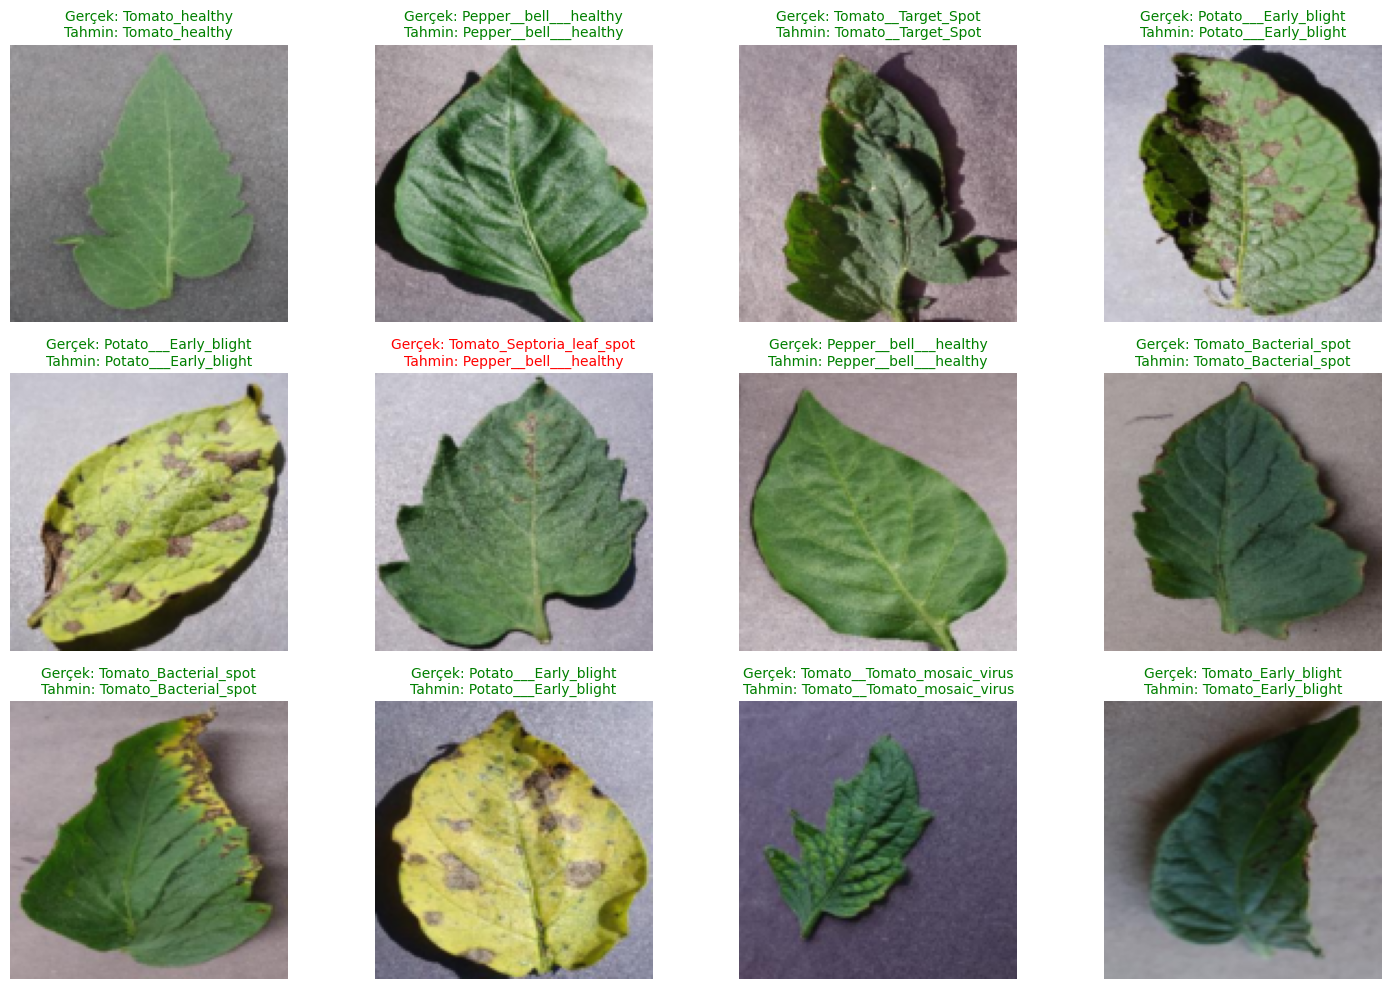

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_model_predictions(model, loader, class_names, num_images=12):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(3, 4, images_so_far) # 3 satır, 4 sütun
                ax.axis('off')
                
                # Görüntüyü PyTorch tensöründen (C, H, W) -> Numpy (H, W, C) formatına çevir
                img = inputs.cpu().data[j].permute(1, 2, 0).numpy()
                
                # Görüntü normalize edildiyse geri al (0-1 arası olduğu için gerek yok ama clipped)
                img = np.clip(img, 0, 1)
                
                actual = class_names[labels[j]]
                predicted = class_names[preds[j]]
                
                # Başlık rengi: Doğruysa Yeşil, Yanlışsa Kırmızı
                color = 'green' if actual == predicted else 'red'
                
                ax.set_title(f"Gerçek: {actual}\nTahmin: {predicted}", color=color, fontsize=10)
                ax.imshow(img)

                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return

# Fonksiyonu çalıştır
visualize_model_predictions(model, val_loader, class_names, num_images=12)

C:\Users\ozkan\AppData\Local\Temp\ipykernel_10952\3095041823.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acc_list, y=class_names, palette="viridis")


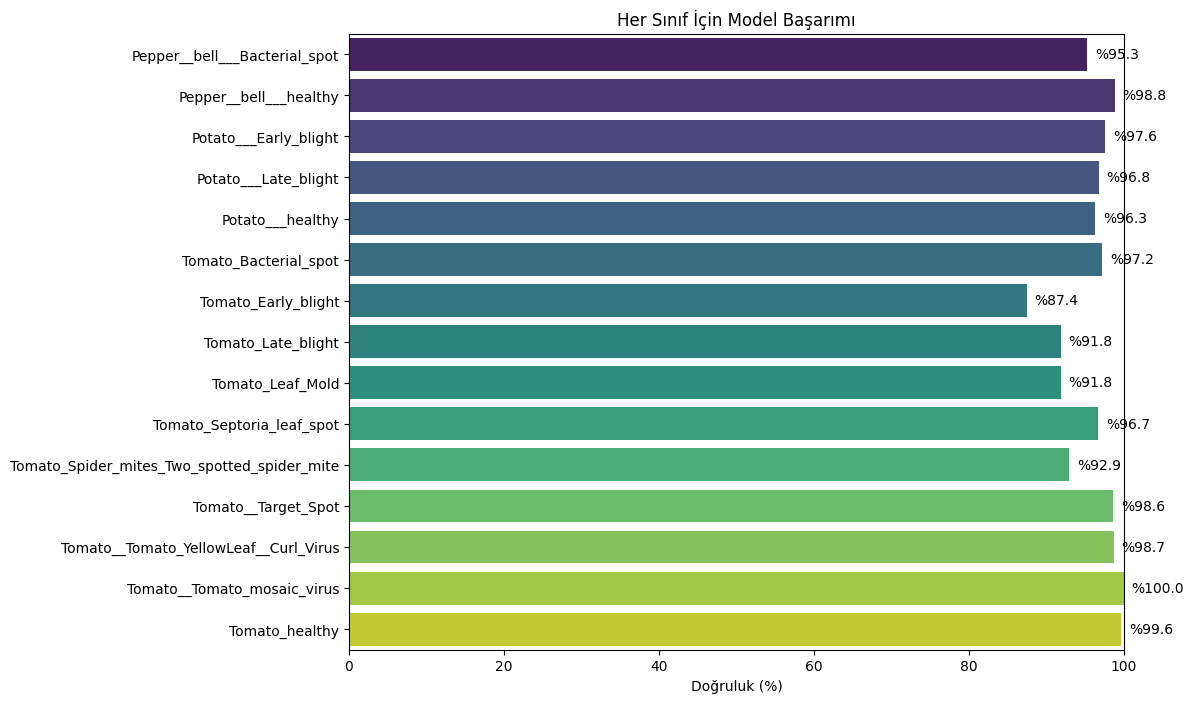

In [11]:
import seaborn as sns

def plot_per_class_accuracy(model, loader, class_names):
    model.eval()
    class_correct = list(0. for i in range(len(class_names)))
    class_total = list(0. for i in range(len(class_names)))
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            c = (predicted == labels).squeeze()
            
            # Batch boyutu kadar dön
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # Doğruluk oranlarını hesapla
    acc_list = []
    for i in range(len(class_names)):
        acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        acc_list.append(acc)

    # Görselleştirme (Yatay Bar Grafiği)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=acc_list, y=class_names, palette="viridis")
    plt.xlabel('Doğruluk (%)')
    plt.title('Her Sınıf İçin Model Başarımı')
    plt.xlim(0, 100)
    
    # Barların ucuna değerleri yaz
    for i, v in enumerate(acc_list):
        plt.text(v + 1, i, f"%{v:.1f}", color='black', va='center')
        
    plt.show()

plot_per_class_accuracy(model, val_loader, class_names)

C:\Users\ozkan\AppData\Local\Temp\ipykernel_10952\47497097.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="magma")


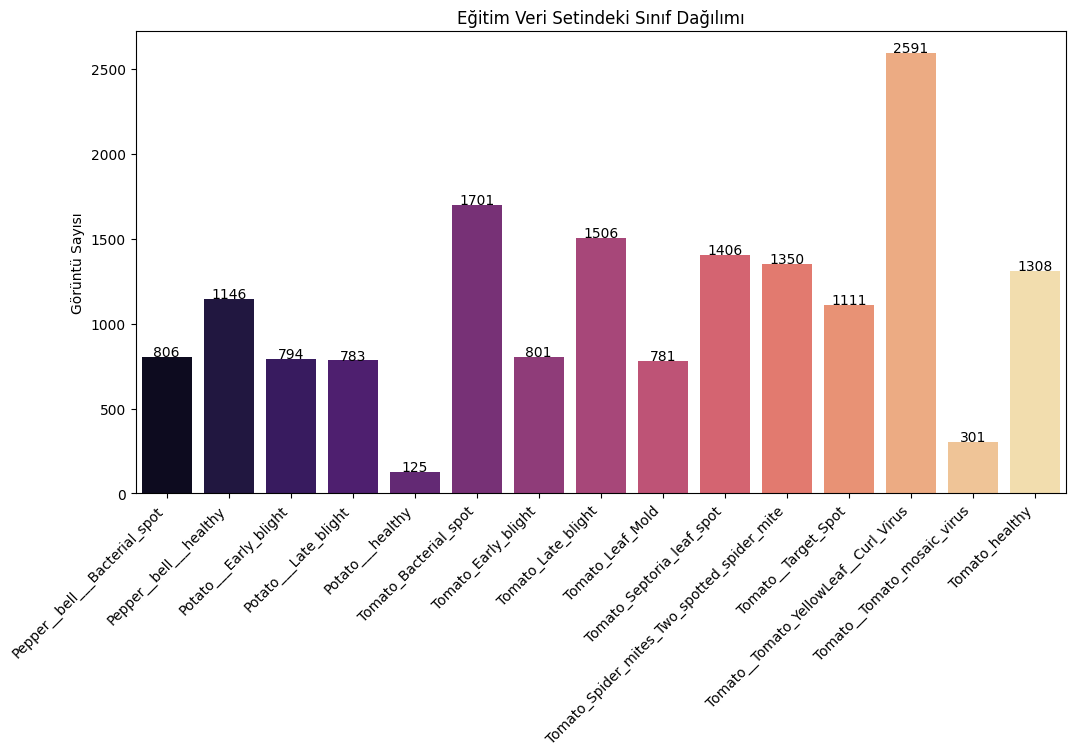

In [12]:
def plot_class_distribution(dataset, class_names):
    # Dataset içindeki tüm etiketleri say
    # Not: Subset kullanıldığı için dataset.indices üzerinden gitmemiz gerekebilir
    # Eğer doğrudan ImageFolder ise dataset.targets yeterli.
    
    count_dict = {name: 0 for name in class_names}
    
    # dataset bir Subset nesnesi ise
    if hasattr(dataset, 'indices'):
        # Ana datasetten (dataset.dataset) sadece subset indislerini al
        targets = [dataset.dataset.targets[i] for i in dataset.indices]
    else:
        # Doğrudan ImageFolder ise
        targets = dataset.targets
        
    for t in targets:
        count_dict[class_names[t]] += 1
        
    names = list(count_dict.keys())
    values = list(count_dict.values())
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=names, y=values, palette="magma")
    plt.xticks(rotation=45, ha='right') # İsimler uzunsa yan çevir
    plt.ylabel('Görüntü Sayısı')
    plt.title('Eğitim Veri Setindeki Sınıf Dağılımı')
    
    # Sayıları barların üzerine yaz
    for i, v in enumerate(values):
        plt.text(i, v + 5, str(v), ha='center', color='black')
        
    plt.show()

# Sadece eğitim verisinin dağılımını çizelim
plot_class_distribution(train_dataset, class_names)